# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [9]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import json
import os

# Import API key
from api_keys import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [10]:
# Load the weatherpy_data.csv file
weatherpy_data_csv = "../output_data/weatherpy_data.csv"

# Create a dataframe with imported csv file
weatherpy_data_df = pd.read_csv(weatherpy_data_csv)

# Display dataframe
weatherpy_data_df.head()

,Unnamed: 0,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,0,jamestown,1,US,1602989705,48,42.10,-79.24,45.00,6.93
1,1,puerto ayora,91,EC,1602989713,86,-0.74,-90.35,71.01,4.00
2,2,bluff,56,NZ,1602989713,66,-46.60,168.33,53.01,7.00
3,3,bredasdorp,100,ZA,1602989713,93,-34.53,20.04,53.60,5.82
4,4,ancud,90,CL,1602989713,93,-41.87,-73.82,48.99,12.75


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [11]:
# Configure gmaps
gmaps.configure(api_key=g_key)

In [12]:
# Count current total records for the new dataframe
weatherpy_data_df.count()

Unnamed: 0    566
City          566
Cloudiness    566
Country       562
Date          566
Humidity      566
Lat           566
Lng           566
Max Temp      566
Wind Speed    566
dtype: int64

In [13]:
# Drop NaN values on the dataframe
weatherpy_data_df = weatherpy_data_df.dropna()

weatherpy_data_df.count()

Unnamed: 0    562
City          562
Cloudiness    562
Country       562
Date          562
Humidity      562
Lat           562
Lng           562
Max Temp      562
Wind Speed    562
dtype: int64

In [14]:
# Use the Lat & Lng as locations
locations = weatherpy_data_df[["Lat","Lng"]].astype(float)

# Use Humidity as the weight
humidity = weatherpy_data_df["Humidity"].astype(float)


# Create a Humidity heatmap
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=humidity, dissipating=False, 
                                 max_intensity=max(weatherpy_data_df["Humidity"]),
                                point_radius = 1)

fig.add_layer(heat_layer)

fig


Figure(layout=FigureLayout(height='420px'))

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [15]:
# Create a new dataframe for ideal weather conditions
ideal_weather_df = weatherpy_data_df
ideal_weather_df

# Adding condition of max temperature higher than 70 degrees
ideal_weather_df = ideal_weather_df[ideal_weather_df['Max Temp'] >= 70] 

# Adding condition of max temperature lower than 80 degrees
ideal_weather_df = ideal_weather_df[ideal_weather_df['Max Temp'] <= 80] 

# Adding condition of wind speed less than 10 mph
ideal_weather_df = ideal_weather_df[ideal_weather_df['Wind Speed'] < 10]

# Adding condition of zero cloudiness 
ideal_weather_df = ideal_weather_df[ideal_weather_df['Cloudiness'] == 0]
ideal_weather_df

# Drop any rows that don't contain all three conditions
ideal_weather_df = ideal_weather_df.dropna()
ideal_weather_df.count()

# Reset index number on the new dataframe
ideal_weather_df = ideal_weather_df.reset_index()
ideal_weather_df

,index,Unnamed: 0,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,12,12,busselton,0,AU,1602989489,33,-33.65,115.33,75.99,5.57
1,75,75,vao,0,NC,1602989721,61,-22.67,167.48,71.96,9.64
2,90,90,binzhou,0,CN,1602989723,29,37.37,118.02,72.00,7.63
3,113,113,miram shah,0,PK,1602989726,19,33.01,70.07,71.13,7.00
4,249,249,sharjah,0,AE,1602989741,39,25.36,55.40,75.20,3.36
5,287,287,xuddur,0,SO,1602989746,88,4.12,43.89,70.90,8.95
6,339,339,nioro,0,GM,1602989753,87,13.35,-15.75,77.76,5.19
7,368,368,abu dhabi,0,AE,1602989658,38,24.47,54.37,77.00,4.70
8,382,382,rondonopolis,0,BR,1602989604,64,-16.47,-54.64,76.59,2.48
9,400,400,bandarbeyla,0,SO,1602989760,77,9.49,50.81,78.96,8.39


In [16]:
### Hotel Map
# Store into variable named `hotel_df`
hotel_df = ideal_weather_df
hotel_df

# Add a "Hotel Name" column to the DataFrame.
hotel_df["Hotel Name"] = ""
hotel_df

# Set variable for searching for hotel names
hotel_search = []

# Set parameters to search for hotels with 5000 meters.
params = {
    "radius": 5000, 
    "types":"hotel",
    "keyword":"hotel",
    "key": g_key
}

# Hit the Google Places API for each city's coordinates.
# Use the Lat & Lng to identify hotels
for index, row in hotel_df.iterrows():
    # Retrieve Lat & Lng from hotel dataframe
    lat = row["Lat"]
    lng = row["Lng"]

    # Change location each iteration while leaving orginal params in place
    params["location"] = f"{lat},{lng}"
    
    # Set up base_url
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    
    # Make request and print url
    hotel_name = requests.get(base_url, params=params).json()
     
    # Store the first Hotel result into the DataFrame
    try:
        hotel_search.append(hotel_name['results'][0]['name'])
    
    # Create message to skip missing data and keep loop running
    except:
        hotel_search.append(np.nan)
        print("Missing field/result... skipping.")

# Append searched hotel names to dataframe
hotel_df['Hotel Name'] = hotel_search

# Display complete result
hotel_df

Missing field/result... skipping.


,index,Unnamed: 0,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,Hotel Name
0,12,12,busselton,0,AU,1602989489,33,-33.65,115.33,75.99,5.57,Esplanade Hotel
1,75,75,vao,0,NC,1602989721,61,-22.67,167.48,71.96,9.64,OURE TERA beach resort
2,90,90,binzhou,0,CN,1602989723,29,37.37,118.02,72.00,7.63,Binzhou Hotel
3,113,113,miram shah,0,PK,1602989726,19,33.01,70.07,71.13,7.00,Bravo
4,249,249,sharjah,0,AE,1602989741,39,25.36,55.40,75.20,3.36,Sheraton Sharjah Beach Resort & Spa
5,287,287,xuddur,0,SO,1602989746,88,4.12,43.89,70.90,8.95,Hotel Kontome 2
6,339,339,nioro,0,GM,1602989753,87,13.35,-15.75,77.76,5.19,NaN
7,368,368,abu dhabi,0,AE,1602989658,38,24.47,54.37,77.00,4.70,Royal M Hotel & Resort Abu Dhabi
8,382,382,rondonopolis,0,BR,1602989604,64,-16.47,-54.64,76.59,2.48,Comfort Hotel & Suites Rondonópolis
9,400,400,bandarbeyla,0,SO,1602989760,77,9.49,50.81,78.96,8.39,Super secret pirate cove


In [17]:
# Create clean dataframe by removing NaN records
hotel_df = hotel_df.dropna()
hotel_df = hotel_df.drop('Unnamed: 0',1)

# Select top 8 cities with minimum humidity 
hotel_df = hotel_df.nsmallest(8, 'Humidity')

# Reset index number for selected records
hotel_df = hotel_df.reset_index()

# Display updated dataframe
hotel_df

,level_0,index,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,Hotel Name
0,3,113,miram shah,0,PK,1602989726,19,33.01,70.07,71.13,7.00,Bravo
1,11,451,awbari,0,LY,1602989767,19,26.59,12.78,74.80,6.71,فندق أوباري
2,10,437,dangara,0,IN,1602989765,24,29.68,75.89,78.24,2.80,Hotel Pink Stone Tohana
3,2,90,binzhou,0,CN,1602989723,29,37.37,118.02,72.00,7.63,Binzhou Hotel
4,0,12,busselton,0,AU,1602989489,33,-33.65,115.33,75.99,5.57,Esplanade Hotel
5,7,368,abu dhabi,0,AE,1602989658,38,24.47,54.37,77.00,4.70,Royal M Hotel & Resort Abu Dhabi
6,4,249,sharjah,0,AE,1602989741,39,25.36,55.40,75.20,3.36,Sheraton Sharjah Beach Resort & Spa
7,1,75,vao,0,NC,1602989721,61,-22.67,167.48,71.96,9.64,OURE TERA beach resort


In [18]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

In [19]:
# Add marker layer ontop of heat map
hotel_marker = gmaps.marker_layer(locations, info_box_content = hotel_info)

# Add the layer to the heat map
fig.add_layer(hotel_marker)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

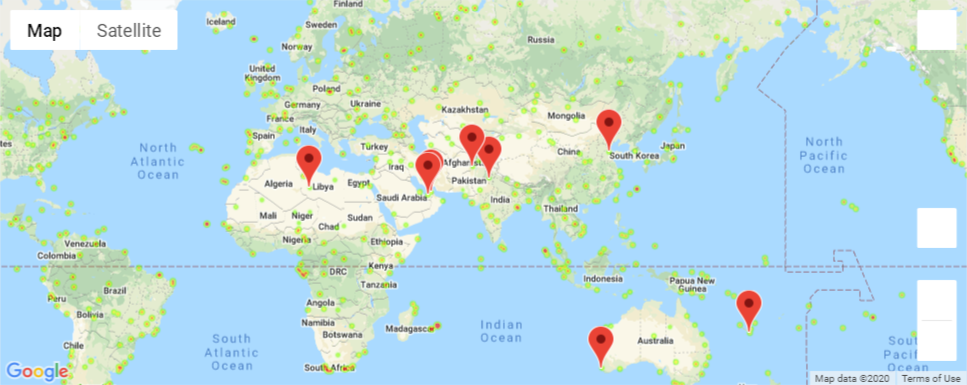

In [5]:
from IPython.display import Image
Image(filename="../Images/Hotel_Heatmap1.png")


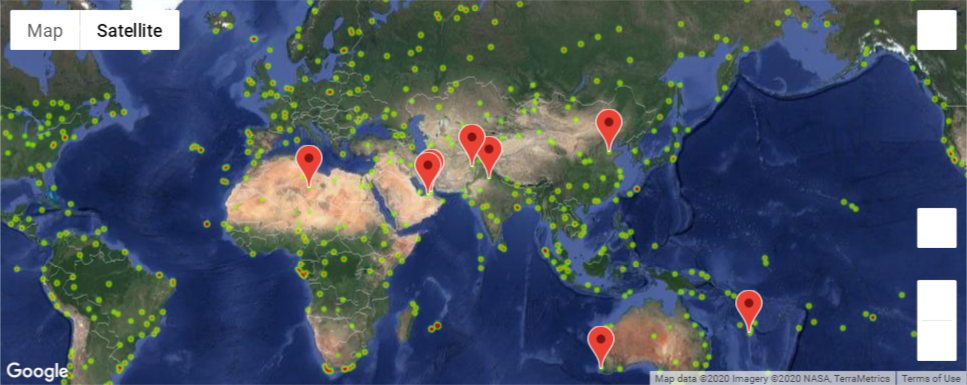

In [7]:
Image(filename="../Images/Hotel_Heatmap2.png")